# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from matplotlib_venn import venn2

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
#pip install git+https://github.com/alemartinello/dstapi

In [97]:
import pandas as pd
from IPython.display import display
import requests
from dstapi import DstApi

NAN1 = DstApi('NAN1') 
display(NAN1.tablesummary(language='en'))

Table NAN1: Demand and supply by transaction, price unit and time
Last update: 2024-03-27T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TRANSAKT,31,B1GQK,B.1*g Gross domestic product,EMPM_DC,"Total employment (1,000 persons)",False
1,PRISENHED,6,V_M,"Current prices, (bill. DKK.)",LAN_C,"Pr. capita, 2010-prices, chained values, (1000...",False
2,Tid,58,1966,1966,2023,2023,True


In [98]:
NAN1.variable_levels('TRANSAKT', language='en')

,id,text
0,B1GQK,B.1*g Gross domestic product
1,P7K,P.7 Imports of goods and services
2,P71K,P.71 Import of goods
3,P72K,P.72 Import of services
4,TFSPR,Supply
5,P6D,P.6 Exports of goods and services
6,P61D,P.61 Export of goods
7,P62D,P.62 Export of services
8,P31S1MD,P.31 Private consumption
9,P31S14D,P.31 Household consumption expenditure


In [99]:
params = NAN1._define_base_params(language = 'en')
params

{'table': 'nan1',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'TRANSAKT', 'values': ['*']},
  {'code': 'PRISENHED', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [100]:
params = {'table': 'nan1',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'TRANSAKT', 'values': ['B1GQK']},
  {'code': 'PRISENHED', 'values': ['L_V']},
  {'code': 'Tid', 'values': ['*']}]}

NAN1.get_data(params=params)

,TRANSAKT,PRISENHED,TID,INDHOLD
0,B.1*g Gross domestic product,Period-to-period real growth (per cent),1979,3.9
1,B.1*g Gross domestic product,Period-to-period real growth (per cent),2022,2.7
2,B.1*g Gross domestic product,Period-to-period real growth (per cent),2005,2.3
3,B.1*g Gross domestic product,Period-to-period real growth (per cent),1985,4.0
4,B.1*g Gross domestic product,Period-to-period real growth (per cent),1991,1.4
5,B.1*g Gross domestic product,Period-to-period real growth (per cent),2007,0.9
6,B.1*g Gross domestic product,Period-to-period real growth (per cent),2020,-2.4
7,B.1*g Gross domestic product,Period-to-period real growth (per cent),1982,3.7
8,B.1*g Gross domestic product,Period-to-period real growth (per cent),2010,1.9
9,B.1*g Gross domestic product,Period-to-period real growth (per cent),2011,1.3


In [101]:
from dataproject import*
BNP = data_NAN1()

In [102]:
drop_these = ['TRANSAKT','PRISENHED']
BNP.drop(drop_these, axis=1, inplace=True)
BNP.rename(columns = {'INDHOLD':'g'}, inplace=True)
I = BNP.loc[BNP.g == '..'] 
BNP.drop(I.index, inplace=True)
BNP.sort_values(by = ['TID'], inplace=True)
BNP['g'] = BNP['g'].astype('float')
BNP.head()


,TID,g
41,1967,5.5
51,1968,5.6
29,1969,6.5
12,1970,1.6
49,1971,3.0


In [103]:
HIS = data_HISB3()
HIS.sort_values(by = ['TID','BEVÆGELSE'], inplace=True)
even = HIS.iloc[::2]
odd = HIS.iloc[1::2]
even.rename(columns={'INDHOLD':'births'}, inplace=True)
print(even)
odd.rename(columns = {'INDHOLD': 'women'}, inplace=True)

res = pd.merge(even, odd, how='inner', on=['TID'])


                      BEVÆGELSE   TID births
181  Total number of livebirths  1901  73219
87   Total number of livebirths  1902  72839
52   Total number of livebirths  1903  72351
104  Total number of livebirths  1904  73692
53   Total number of livebirths  1905  73082
..                          ...   ...    ...
169  Total number of livebirths  2020  60937
97   Total number of livebirths  2021  63473
79   Total number of livebirths  2022  58430
119  Total number of livebirths  2023  57469
81   Total number of livebirths  2024     ..

[124 rows x 3 columns]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20980\2708883171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  even.rename(columns={'INDHOLD':'births'}, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20980\2708883171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odd.rename(columns = {'INDHOLD': 'women'}, inplace=True)


In [104]:
res.head()
drop = ['BEVÆGELSE_x', 'BEVÆGELSE_y']
res.drop(drop,axis=1,inplace=True)

In [105]:
res.head()
res = res.dropna()
I = res.loc[res.births == '..'] 
res.drop(I.index, inplace=True)
I_2 = res.loc[res.women == '..'] 
res.drop(I_2.index, inplace=True)

In [106]:
res['births'] = res['births'].astype('float')
res['women'] = res['women'].astype('float')

In [107]:
res['fertility'] = res['births']/res['women']
res.head()

,TID,births,women,fertility
0,1901,73219.0,1255.0,58.341833
1,1902,72839.0,1271.0,57.308419
2,1903,72351.0,1286.0,56.260498
3,1904,73692.0,1300.0,56.686154
4,1905,73082.0,1316.0,55.533435


In [108]:
inner = pd.merge(res,BNP, how = 'inner', on = ['TID'])
inner = inner.set_index('TID')
inner.tail()

,births,women,fertility,g
TID,,,,
2019,61167.0,2917.0,20.969146,1.5
2020,60937.0,2926.0,20.826042,-2.4
2021,63473.0,2935.0,21.626235,6.8
2022,58430.0,2951.0,19.800068,2.7
2023,57469.0,2984.0,19.259048,1.9


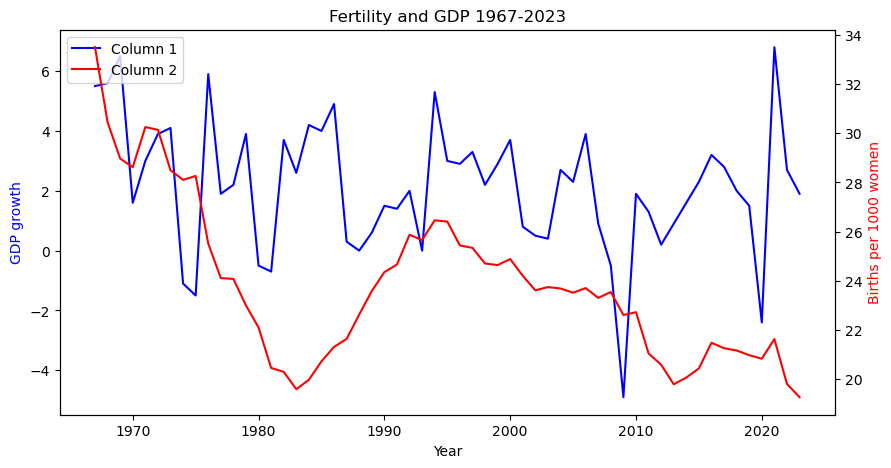

In [114]:
# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first column on the primary y-axis
ax1.plot(inner.index, inner['g'], color='b', label='Column 1')
ax1.set_xlabel('Year')
ax1.set_ylabel('GDP growth', color='b')

# Create a secondary y-axis
ax2 = ax1.twinx()  # Use twinx() instead of twiny()
ax2.plot(inner.index, inner['fertility'], color='r', label='Column 2')
ax2.set_ylabel('Births per 1000 women', color='r')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Fertility and GDP 1967-2023')

# Show plot
plt.show()

# Read and clean data

Import your data, either through an API or manually, and load it. 

## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [ ]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

In [ ]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

NameError: name 'venn2' is not defined

<Figure size 1500x700 with 0 Axes>

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.